In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import requests
from PIL import Image
from io import BytesIO
import cv2
import pandas as pd
import numpy as np
import os

In [2]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1UlOk6EtiaXTHylRUx2mySgvJX9ycoeBp',
                                    dest_path='./data/file.zip',
                                    unzip=True)

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Unzipping...Done.


In [3]:
foldernames = os.listdir('/kaggle/working/data/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset')
files, files2 = [], []

for i, folder in enumerate(foldernames):
    filenames = os.listdir("/kaggle/working/data/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset" + "/" + folder);
    for file in filenames:
        files.append("/kaggle/working/data/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset" + "/" + folder + "/" + file)

foldernames = os.listdir('/kaggle/working/data/self-built-masked-face-recognition-dataset/AFDB_face_dataset')
for i, folder in enumerate(foldernames):
    filenames = os.listdir("/kaggle/working/data/self-built-masked-face-recognition-dataset/AFDB_face_dataset" + "/" + folder);
    for file in filenames:
        files2.append("/kaggle/working/data/self-built-masked-face-recognition-dataset/AFDB_face_dataset" + "/" + folder + "/" + file)

df = pd.DataFrame({'Filepath':files, 'Target':'Y'})
df2 = pd.DataFrame({'Filepath':files2, 'Target':'N'})
#dft = pd.DataFrame({'Filepath':files2, 'Target':target2})

df = df[:4000]
df2 = df2[:4000]
df = pd.concat([df, df2], ignore_index=True)
train, test = train_test_split(df, test_size=0.2, random_state = 0)
#delete files, files2, df2

In [4]:
datagen = ImageDataGenerator(rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        #rotation_range=30, 
        #width_shift_range=0.1,
        #height_shift_range=0.1,
        samplewise_center = True,
        )

datagen_test = ImageDataGenerator(rescale=1./255, samplewise_center = True)

train_flow = datagen.flow_from_dataframe(train, x_col = 'Filepath', y_col = 'Target', target_size=(224, 224), batch_size=128, class_mode="binary", interpolation = 'bicubic')
test_flow = datagen_test.flow_from_dataframe(test, x_col = 'Filepath', y_col = 'Target', target_size=(224, 224), batch_size=128, class_mode="binary", interpolation = 'bicubic')

Found 4962 validated image filenames belonging to 2 classes.
Found 1241 validated image filenames belonging to 2 classes.


In [7]:
model = applications.ResNet50V2(weights = None, include_top = False, input_shape=(224, 224, 3))

#model.get_layer('block1_conv1').trainable = False
#model.get_layer('block1_conv2').trainable = False
#model.get_layer('block2_conv1').trainable = False
#model.get_layer('block2_conv2').trainable = False

flat1 = tf.keras.layers.Flatten()(model.output)
#dropout1 = Dropout(0.1)(flat1)
class1 = tf.keras.layers.Dense(512, activation='relu')(flat1)
#dropout2 = Dropout(0.1)(class1)
output = tf.keras.layers.Dense(1, activation='sigmoid')(class1)
model = Model(inputs = model.inputs, outputs = output)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.0001, min_lr = 1e-8)

model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(lr=1e-3, momentum=0.9), metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [8]:
history = model.fit_generator(train_flow, epochs = 10, validation_data = test_flow, callbacks=[ModelCheckpoint('modelx.model', monitor='val_acc'), reduce_lr])

Epoch 1/10
39/39 [==============================] - 59s 2s/step - loss: 0.4570 - accuracy: 0.7940 - val_loss: 0.5996 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 2/10
39/39 [==============================] - 57s 1s/step - loss: 0.2054 - accuracy: 0.9246 - val_loss: 0.4633 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 3/10
39/39 [==============================] - 56s 1s/step - loss: 0.1796 - accuracy: 0.9347 - val_loss: 0.4464 - val_accuracy: 0.7840 - lr: 0.0010
Epoch 4/10
39/39 [==============================] - 57s 1s/step - loss: 0.1129 - accuracy: 0.9607 - val_loss: 0.2458 - val_accuracy: 0.9170 - lr: 0.0010
Epoch 5/10
39/39 [==============================] - 57s 1s/step - loss: 0.0911 - accuracy: 0.9667 - val_loss: 0.1831 - val_accuracy: 0.9291 - lr: 0.0010
Epoch 6/10
39/39 [==============================] - 57s 1s/step - loss: 0.0745 - accuracy: 0.9740 - val_loss: 0.1467 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 7/10
39/39 [==============================] - 56s 1s/step - loss: 0.0593 - a

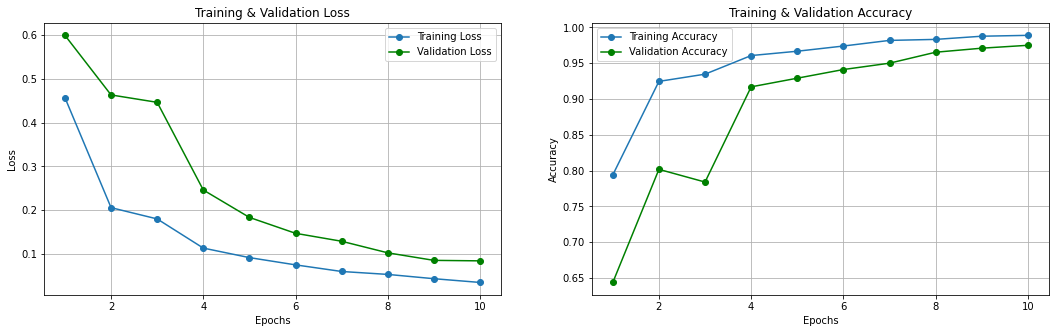

In [9]:
loss_vals = history.history['loss']
val_loss_vals = history.history['val_loss']
epochs = range(1, len(history.history['accuracy'])+1)

f, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    
ax[0].plot(epochs, loss_vals,  marker='o', label='Training Loss')
ax[0].plot(epochs, val_loss_vals, marker='o', color = 'green', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[0].grid(True)

acc_vals = history.history['accuracy']
val_acc_vals = history.history['val_accuracy']

ax[1].plot(epochs, acc_vals, marker='o', label='Training Accuracy')
ax[1].plot(epochs, val_acc_vals, marker='o', color = 'green', label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')
ax[1].grid(True)

plt.show()
f.savefig('LossAndAccuracy.eps', format='eps')
plt.close()
del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

In [10]:
model.save('ResNetModel.h5') 